### Importing Libraries

In [41]:
import torch
import numpy as np
import os
from sklearn.metrics.pairwise import cosine_similarity
from deepface import DeepFace
import cv2
from tqdm import tqdm  # For progress bar
from ultralytics import YOLO
import matplotlib.pyplot as plt
import shutil  # For copying files

### Check if GPU Computing is Available

In [29]:
# Check if a GPU is available and set the device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch is using the GPU.")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. PyTorch is using the CPU.")

CUDA is not available. PyTorch is using the CPU.


### Load Face Detection Model

In [30]:
model = YOLO('yolov8n-face.pt').to(device)

### Setting up variables

In [45]:
# Define paths
image_dir = r'G:\Computer_Vision\Data\Goa'
input_image_path = r'G:\Computer_Vision\Data\Goa\P_20211015_112740.jpg'
output_folder_name = os.path.basename(image_dir) + "_search_results"
results_dir = os.path.join(os.path.dirname(image_dir), output_folder_name)
meta_data_folder = os.path.join(os.path.dirname(image_dir), 'meta_data', os.path.basename(image_dir) + "_embeddings")

### Searching for Images with Same Face

Multiple faces detected. Please choose one:


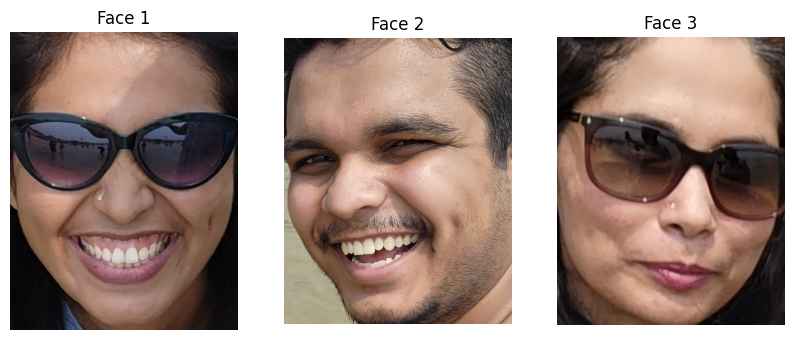

Saving Results: 100%|██████████| 30/30 [00:08<00:00,  3.64image/s]

Similarity search complete. Results saved in 'search_results' folder.


In [47]:
# Create directories for saving results
face_matched_dir = os.path.join(results_dir, 'face_matched')
face_not_matched_dir = os.path.join(results_dir, 'face_not_matched')
os.makedirs(face_matched_dir, exist_ok=True)
os.makedirs(face_not_matched_dir, exist_ok=True)

# Function to load embeddings from the specified directory
def load_embeddings(embeddings_dir):
    embeddings = {}
    for file in os.listdir(embeddings_dir):
        if file.endswith('.npy'):
            name = os.path.splitext(file)[0]
            embeddings[name] = np.load(os.path.join(embeddings_dir, file))
    return embeddings

# Function to find similar faces
def find_similar_faces(input_embedding, embeddings_dict, threshold=0.6):
    similar_faces = []
    for name, emb_list in embeddings_dict.items():
        for emb in emb_list:
            sim = cosine_similarity([input_embedding], [emb])
            if sim[0][0] > threshold:
                similar_faces.append(name)
                break
    return similar_faces

# Function to preprocess face crops
def preprocess_face_crop(face_crop):
    return cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)

# Function to get embeddings
def get_face_embeddings(face_crop):
    try:
        embeddings = DeepFace.represent(img_path=face_crop, model_name='Facenet', enforce_detection=False)
        return embeddings[0]['embedding']
    except Exception as e:
        print(f"Error processing face crop: {e}")
        return None

# Main execution
def main(input_image_path, embeddings_dir, image_dir, face_matched_dir, face_not_matched_dir):
    embeddings_dict = load_embeddings(embeddings_dir)
    input_image = cv2.imread(input_image_path)
    image_rgb = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
    results = model(image_rgb, verbose=False)
    face_crops = []

    for result in results:
        boxes = result.boxes
        for box in boxes:
            xyxy = box.xyxy[0].cpu().numpy()
            conf = box.conf[0].cpu().numpy() if box.conf is not None else 0

            if conf > 0.1:
                x1, y1, x2, y2 = map(int, xyxy)
                face_crop = input_image[y1:y2, x1:x2]
                face_crops.append((face_crop, (x1, y1, x2, y2)))

    if len(face_crops) == 0:
        print("No faces detected in the input image.")
        return
    elif len(face_crops) == 1:
        chosen_face = face_crops[0][0]
    else:
        print("Multiple faces detected. Please choose one:")
        plt.figure(figsize=(10, 5))
        for i, (face_crop, _) in enumerate(face_crops):
            plt.subplot(1, len(face_crops), i + 1)
            plt.imshow(preprocess_face_crop(face_crop))
            plt.axis('off')
            plt.title(f"Face {i + 1}")
        plt.show()

        selected_index = int(input(f"Enter the number of the face you want to search for (1-{len(face_crops)}): ")) - 1
        chosen_face = face_crops[selected_index][0]

    try:
        input_embeddings = get_face_embeddings(preprocess_face_crop(chosen_face))
        input_embedding = input_embeddings
    except Exception as e:
        print(f"Error processing selected face: {e}")
        return

    similar_face_names = find_similar_faces(input_embedding, embeddings_dict)

    # Save results with a progress bar
    with tqdm(total=len(similar_face_names), desc="Saving Results", unit="image") as pbar:
        for name in similar_face_names:
            image_path = os.path.join(image_dir, f"{name}.jpg")
            if os.path.exists(image_path):
                result_path = os.path.join(face_matched_dir, f"{name}.jpg")
                cv2.imwrite(result_path, cv2.imread(image_path))
            else:
                print(f"Image {name}.jpg does not exist in the directory.")
            pbar.update(1)

    # Copy non-matched images to face_not_matched_dir
    matched_names = set(similar_face_names)
    for filename in os.listdir(image_dir):
        if filename.endswith('.jpg'):
            name = os.path.splitext(filename)[0]
            if name not in matched_names:
                src_path = os.path.join(image_dir, filename)
                dest_path = os.path.join(face_not_matched_dir, filename)
                shutil.copy(src_path, dest_path)

    print("Similarity search complete. Results saved in 'search_results' folder.")

# Execute the script
if __name__ == "__main__":
    main(input_image_path, meta_data_folder, image_dir, face_matched_dir, face_not_matched_dir)